In [1]:
from audio_dataset import MelSpectrogram_Classification_Dataset,denormalize

from pathlib import Path

import os

import numpy as np
import pandas as pd

import librosa
import librosa.display

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torchvision.models as torch_models
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler,WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from fastai.vision.all import *

In [2]:
root = '/home/heye0507/sz_audio'
audio_data = root + '/audio_data'
data = root + '/data'

In [3]:
df_train = pd.read_csv(data+'/new_train.csv')
df_valid = pd.read_csv(data+'/new_valid.csv')

In [4]:
df_train.head()

,filename,orig_filename,id,name,eng_name,gender,cul,hometown,age,height,weight,temp,bpm,tsh,t4,t3,tsh_label,t3_label,t4_label
0,train_0043.wav,524215/Ausculation_Report_Eko_Recording_140111.wav,524215,叶思思,"Ye, Sisi",1=男,1=汉族,温州,35,164.0,64.0,36.5,80.0,1.12,8.32,4.6,1,0,0
1,train_0209.wav,524215/Ausculation_Report_Eko_Recording_140114.wav,524215,叶思思,"Ye, Sisi",1=男,1=汉族,温州,35,164.0,64.0,36.5,80.0,1.12,8.32,4.6,1,0,0
2,train_0200.wav,524215/Ausculation_Report_Eko_Recording_140112.wav,524215,叶思思,"Ye, Sisi",1=男,1=汉族,温州,35,164.0,64.0,36.5,80.0,1.12,8.32,4.6,1,0,0
3,train_0201.wav,524215/Ausculation_Report_Eko_Recording_140113.wav,524215,叶思思,"Ye, Sisi",1=男,1=汉族,温州,35,164.0,64.0,36.5,80.0,1.12,8.32,4.6,1,0,0
4,train_0159.wav,615897/Ausculation_Report_Eko_Recording_141773.wav,615897,叶晓霞,"Ye,Xiaoxia",2=女,1=汉族,永嘉,69,156.0,50.0,36.9,60.0,2.53,12.34,4.2,1,0,0


In [4]:
def get_train_transform():
    return A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        #A.Resize(height=512,width=512,p=1.0),
        A.Normalize(p=1.0),
        ToTensorV2(p=1.0),
    ],p=1.0)

def get_valid_transform():
    return A.Compose([
        #A.Resize(height=512,width=512,p=1.0),
        A.Normalize(p=1.0),
        ToTensorV2(p=1.0),
    ],p=1.0)

In [5]:
train_ds = MelSpectrogram_Classification_Dataset(df_train,audio_data,img_tfms=get_train_transform())
valid_ds = MelSpectrogram_Classification_Dataset(df_valid,audio_data,img_tfms=get_valid_transform())

In [6]:
#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish
class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x * (torch.tanh(F.softplus(x)))

In [7]:
class Model_Head(nn.Module):
    def __init__(self,ni,nc,ps=0.25):
        '''
        ni : input filter size
        nc : output class size
        ps : dropout rate
        '''
        super().__init__()
        layers = ([Mish(),ConvLayer(ni,ni,act_cls=None),AdaptiveConcatPool2d(),
                   Flatten(), LinBnDrop(ni*2,512,p=ps,act=Mish()), 
                   LinBnDrop(512,nc,p=ps*2)])
        self.head = nn.Sequential(*layers)
    
    def forward(self,xb):
        return self.head(xb)
    
class Resnet_audio(nn.Module):
    def __init__(self,arch,nc=[2,2,2],pretrained=True):
        super().__init__()
        self.body = nn.Sequential(*list(arch(pretrained=pretrained).children())[:-2])
       
        # change input filter size to 1
#         nf,ni,h,w = self.body[0].weight.shape
#         w = self.body[0].weight.sum(dim=1,keepdim=True)
#         conv_input = conv2d(1,nf,ks=h)
#         conv_input.weight.data = w
#         self.body[0] = conv_input
        
        # multi-head output
        # 1,1,1 regression head
        ni = num_features_model(self.body)
        self.head_tsh = Model_Head(ni,nc[0])
        self.head_t3 = Model_Head(ni,nc[1])
        self.head_t4 = Model_Head(ni,nc[2])
    
    def forward(self,x):
        x = self.body(x)
        return (self.head_tsh(x),self.head_t3(x),self.head_t4(x))
    
# replace all relu layer with Mish        
def to_mish(model):
    for name,child in model.named_children():
        if isinstance(child,nn.ReLU):
            setattr(model,name,Mish())
        else:
            to_mish(child)

In [8]:
model = Resnet_audio(torch_models.resnet34).cuda()

In [9]:
class Loss_multi_head(nn.Module):
    def __init__(self,weights=[1,1,1]):
        super().__init__()
        self.weights = weights
        
    def forward(self,preds,target,reduction='mean'):
        outp_tsh,outp_t3,outp_t4 = preds
        outp_tsh,outp_t3,outp_t4 = outp_tsh.float(),outp_t3.float(),outp_t4.float()
        targ_tsh,targ_t3,targ_t4 = target[0]
        #targ_tsh,targ_t3,targ_t4 = targ_tsh.argmax(1).long(), targ_t3.argmax(1).long(),targ_t4.argmax(1).long()
        return (
            self.weights[0] * F.cross_entropy(outp_tsh,targ_tsh.long(),reduction=reduction) 
            + self.weights[1] * F.cross_entropy(outp_t3,targ_t3.long(),reduction=reduction) 
            + self.weights[2] * F.cross_entropy(outp_t4,targ_t4.long(),reduction=reduction)
               )
        

In [10]:
loss_func = Loss_multi_head()

In [11]:
from fastai.data.core import DataLoaders

In [12]:
tr_dl = DataLoader(train_ds,batch_size=32,num_workers=4)
vl_dl = DataLoader(valid_ds,batch_size=32,num_workers=4)

In [140]:
dls = DataLoaders(train_loader,vl_dl,device='cuda')

In [141]:
learn = Learner(dls,model,loss_func=loss_func)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.25118863582611084)

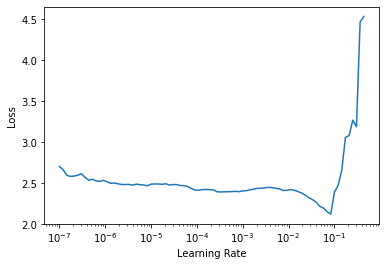

In [142]:
learn.lr_find()

In [143]:
learn.fit_one_cycle(20,3e-3)

epoch,train_loss,valid_loss,time
0,2.517155,2.486315,00:12
1,2.502621,2.330992,00:12
2,2.394994,6.861426,00:12
3,2.230559,22.915606,00:12
4,2.043888,15.530986,00:11
5,1.876049,1.333786,00:11
6,1.672828,0.838802,00:12
7,1.527433,0.870987,00:12
8,1.430030,1578.395752,00:11
9,1.346298,79.824951,00:12


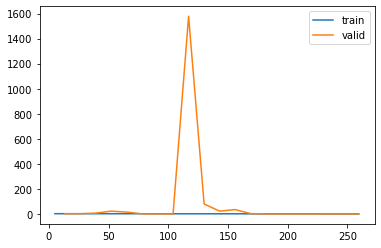

In [144]:
learn.recorder.plot_loss()

In [147]:
x,y = dls[0].one_batch()

In [148]:
preds = learn.model(x)

In [149]:
tsh,t3,t4 = preds

In [150]:
tsh.argmax(-1),y[0][0].argmax(1)

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [151]:
t3.argmax(-1),y[0][1].argmax(1)

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [152]:
t4.argmax(-1),y[0][2].argmax(1)

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'))

In [153]:
tsh,t3,t4 = [],[],[]
g_tsh,g_t3,g_t4 = [],[],[]
for x,y in dls[0]:
    preds = learn.model(x)
    tsh.append(preds[0].argmax(-1))
    t3.append(preds[1].argmax(-1))
    t4.append(preds[2].argmax(-1))
    g_tsh.append(y[0][0].argmax(1))
    g_t3.append(y[0][1].argmax(1))
    g_t4.append(y[0][2].argmax(1))

In [154]:
tsh,g_tsh

([tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
  tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [69]:
learn.save(root+'/baseline')

Path('/home/heye0507/sz_audio/baseline.pth')

In [99]:
from collections import Counter
count = Counter(df_train['tsh_label'].sort_values()).values()
class_weights = 1/np.array(list(count))
# dsets = block.datasets(df_mix)
# wgts = class_weights[dsets.train.items['label']]
# dls = block.dataloaders(df_mix, bs=bs,num_workers=num_workers,dl_type=WeightedDL,wgts=wgts)
wgts = class_weights[df_train['tsh_label']]

In [107]:
weights = torch.from_numpy(wgts)
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights.double(), len(weights))
#trainloader = torch.utils.data.DataLoader(trainDataset, batch_size = batch_size, sampler = sampler)

In [108]:
tr_dl = DataLoader(train_ds,batch_size=32,num_workers=4,sampler=sampler)

In [109]:
b = next(iter(tr_dl))

In [104]:
b[0].shape

torch.Size([32, 3, 128, 235])

In [110]:
b[1][0][0].argmax(1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [111]:
b[1][0][1].argmax(1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
target = df_train['tsh_label']
print ('target train 0/1: {}/{}'.format(
    len(np.where(target == 0)[0]), len(np.where(target == 1)[0])))

target train 0/1: 356/38


In [13]:
class_sample_count = np.array(
    [len(np.where(target == t)[0]) for t in np.unique(target)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in target])

In [14]:
samples_weight = torch.from_numpy(samples_weight)
samples_weigth = samples_weight.double()
sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [15]:
target = torch.from_numpy(np.array(target.to_list())).long()
train_dataset = train_ds

In [16]:
train_loader = DataLoader(
    train_dataset, batch_size=32, num_workers=1, sampler=sampler)

for i, (data, target) in enumerate(train_loader):
    print ("batch index {}, 0/1: {}/{}".format(
        i,
        len(np.where(target[0][0].numpy() == 0)[0]),
        len(np.where(target[0][0].numpy() == 1)[0])))

batch index 0, 0/1: 32/0
batch index 1, 0/1: 32/0
batch index 2, 0/1: 32/0
batch index 3, 0/1: 32/0
batch index 4, 0/1: 24/8
batch index 5, 0/1: 32/0
batch index 6, 0/1: 32/0
batch index 7, 0/1: 32/0
batch index 8, 0/1: 32/0
batch index 9, 0/1: 32/0
batch index 10, 0/1: 12/20
batch index 11, 0/1: 22/10
batch index 12, 0/1: 10/0


In [160]:
train_loader = DataLoader(
    train_dataset, batch_size=32, num_workers=1, sampler=sampler)

In [161]:
b = next(iter(train_loader))

In [162]:
b[0].shape

torch.Size([32, 3, 128, 235])

In [21]:
b = dls.one_batch()

In [22]:
preds = model(b[0])

In [23]:
b[0].shape,len(b[1])

(torch.Size([32, 3, 128, 235]), 2)

In [25]:
preds[0]

tensor([[ 5.2339e-01,  2.6513e+00],
        [-1.0611e+00, -5.5601e-01],
        [-1.4252e-01,  6.1985e-01],
        [-7.4188e-02,  1.3731e-01],
        [ 2.2829e-01, -5.2692e-01],
        [ 2.4270e-01, -1.2136e+00],
        [ 8.4924e-01,  4.8941e-01],
        [-7.3959e-02, -7.4454e-02],
        [-1.9701e+00, -1.4676e-01],
        [ 5.3781e-01,  1.1017e+00],
        [-4.7584e-01, -7.6231e-01],
        [ 9.5933e-02, -1.3598e-01],
        [-1.9940e-01,  8.6583e-01],
        [-7.3789e-01,  6.9476e-01],
        [-7.6312e-01,  8.1662e-02],
        [ 1.4507e+00,  1.0320e-01],
        [-2.5671e-02, -4.6011e-01],
        [-1.5554e-01, -5.8408e-01],
        [ 3.5680e-02, -3.3201e-01],
        [ 7.7637e-02, -1.7260e-01],
        [-1.6720e-01, -4.6944e-01],
        [-8.2701e-01, -1.5374e+00],
        [ 1.4266e+00,  9.8722e-01],
        [-2.4453e-01,  2.3863e-03],
        [ 2.0077e-01, -6.7722e-01],
        [-1.8362e+00, -2.7141e-01],
        [-4.0803e-01,  2.0516e-01],
        [ 4.9449e-01, -4.227

In [28]:
b[1][0][0]

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], device='cuda:0')

In [32]:
F.cross_entropy(preds[0],b[1][0][0].argmax(1).long(),reduction='mean')

tensor(0.8608, device='cuda:0', grad_fn=<NllLossBackward>)

In [31]:
b[1][0][0].argmax(1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')